# Can the codon frequency be used to predict the DNAtype and Kingdom? This time using Deep Learning.
---
<b>MADS-DL Portfolio-Exam Part 2<br>
Janosch Höfer, 938969</b>

## Table of contents

- [Introduction](#intro) <br>
- [1. Data preparation](#data-prep) <br>
- [2. Parameters](#parameters) <br>
- [3. Split Data](#split) <br>
- [4. Model setup and Hyperparameter Optimization](#model-setup) <br>
   - [4.1. Neural Network](#NN) <br>
   - [4.2. Cross-validation](#CV) <br>
- [5. Model Evaluation](#eval) <br>
   - [5.1. Codon-Kingdom](#eval-king) <br>
   - [5.2. Codon-DNAtype](#eval-dna) <br>
- [6. Result](#result)<br>
- [References](#ref)<br>

## Introduction

In [1]:
# Standard libraries
import copy
import logging
import os
import random
from datetime import timedelta
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psutil
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn.functional as F
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight

# Own classes and functions
from neuralnet import NeuralNet, load_best_model
from utils import DataModule, compute_metrics

In [2]:
logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

In [3]:
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED, workers=True)

42

In [4]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
device

device(type='cpu')

---
<a id='data-prep'></a>

## 1. Data preparation

In [5]:
data_raw = pd.read_csv("data/codon_usage.csv", sep=",")

C:\Users\hjano\AppData\Local\Temp\ipykernel_38116\3303151036.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data_raw = pd.read_csv("data/codon_usage.csv", sep=",")


In [6]:
# I removed the steps to identify the invalid rows to make the code more concise
# The CSV indices start at 1, while pandas start 0
bad_rows = [
    data_raw[data_raw["UUU"] == "non-B hepatitis virus"].index[0] + 1,
    data_raw[data_raw["UUU"] == "12;I"].index[0] + 1,
]
data_raw = pd.read_csv("data/codon_usage.csv", sep=",", skiprows=bad_rows)

In [7]:
kingdom = data_raw["Kingdom"]
np.sort(kingdom.unique()), kingdom.unique().size

(array(['arc', 'bct', 'inv', 'mam', 'phg', 'plm', 'pln', 'pri', 'rod',
        'vrl', 'vrt'], dtype=object),
 11)

In [8]:
data_king = data_raw.copy(deep=True)

In [9]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(kingdom.unique()):
    condition.append(data_raw["Kingdom"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_king["Kingdom_num"] = np.select(condition, choices)
data_king.groupby("Kingdom_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
Kingdom_num,,,,,,,,,,,,,,,,,,,,,
0,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831,...,2831,2831,2831,2831,2831,2831,2831,2831,2831,2831
1,126,126,126,126,126,126,126,126,126,126,...,126,126,126,126,126,126,126,126,126,126
2,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919,...,2919,2919,2919,2919,2919,2919,2919,2919,2919,2919
3,220,220,220,220,220,220,220,220,220,220,...,220,220,220,220,220,220,220,220,220,220
4,18,18,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
5,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523,...,2523,2523,2523,2523,2523,2523,2523,2523,2523,2523
6,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345,...,1345,1345,1345,1345,1345,1345,1345,1345,1345,1345
7,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077,...,2077,2077,2077,2077,2077,2077,2077,2077,2077,2077
8,572,572,572,572,572,572,572,572,572,572,...,572,572,572,572,572,572,572,572,572,572


In [10]:
labels = ["Kingdom_num"]
complete_data = data_king.iloc[:, 5:]
final_data = data_king.iloc[:, 5:].drop(labels, axis=1)
targets = data_king.loc[:, labels]

---
<a id='parameters'></a>

## 2. Parameters

In [11]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 75
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

---
<a id='split'></a>

## 3. Split Data

In [12]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)

In [13]:
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [14]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7294
val_data:	 size 1824
test_data:	 size 3908


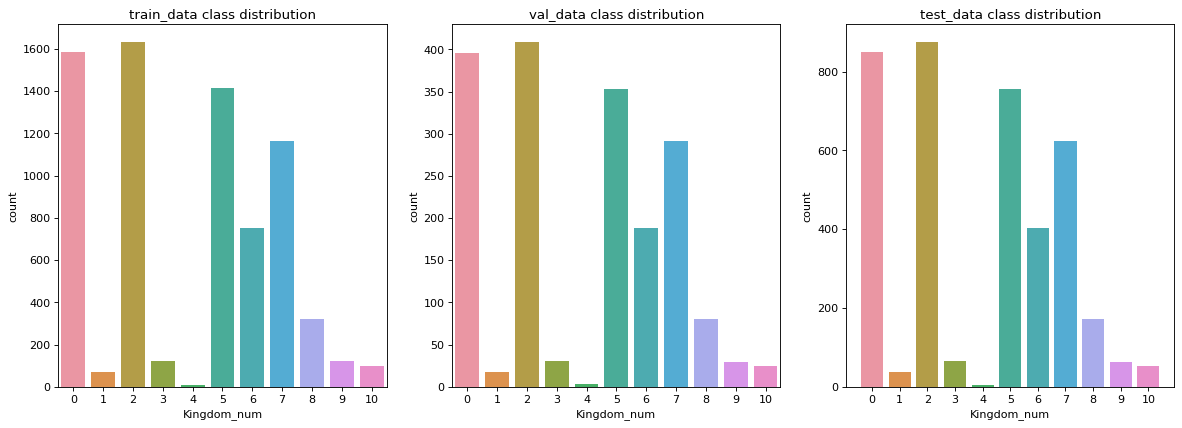

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

---
<a id='model-setup'></a>

## 4. Model setup and Hyperparameter Optimization
<a id='NN'></a>
### 4.1 Neural Network

In [16]:
%load_ext tensorboard
%tensorboard --logdir ./logs/ --host localhost

In [17]:
def train_codons(
    df_train,
    df_val,
    df_test,
    layer_count,
    lr,
    batch_size,
    num_epochs=10,
    core_n=1,
    weights=None,
    dev=False,
    cv=None,
):
    pl.seed_everything(RANDOM_SEED, workers=True)
    data_module = DataModule(
        train_df=df_train,
        test_df=df_test,
        val_df=df_val,
        classes=labels,
        num_workers=core_n,
        batch_size=batch_size,
        device=device,
    )
    model = NeuralNet(
        feature_n, classes_n, lr, layer_count=layer_count, weights=weights, device=device
    )
    if weights is not None:
        w_ind = True
    else:
        w_ind = False
    logger = TensorBoardLogger(
        save_dir="logs",
        name="DL-Exam2",
        version=f"layer={layer_count}-lr={lr}-batchsize={batch_size}-cv={cv}-weights={w_ind}",
    )
    checkpoint_callback = ModelCheckpoint(
        filename="best-checkpoint",
        save_top_k=1,
        monitor="val_balanced_accuracy",
        mode="max",
    )
    callbacks = [checkpoint_callback]
    if device.type == "cuda":
        cuda_kwargs = {"accelerator": "gpu", "devices": 1}
    else:
        cuda_kwargs = dict()
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        logger=logger,
        log_every_n_steps=20,
        callbacks=callbacks,
        fast_dev_run=dev,
        enable_progress_bar=False,
        enable_model_summary=False,
        **cuda_kwargs,
    )
    trainer.fit(model, data_module)
    val_res = trainer.validate(model, data_module, verbose=False)
    test_res = trainer.test(model, data_module, verbose=False)
    params = {
        "hidden_layer": layer_count,
        "learning_rate": lr,
        "batch_size": batch_size,
        "fold": cv,
        "weights": w_ind,
    }
    return {**params, **val_res[0], **test_res[0]}

In [18]:
def hp_optimization(config, df_train, df_val, df_test, num_epochs, dev=False, cv=None):
    runs = list()
    param_count = 0
    for zdx in range(len(config["hidden_layer"])):
        for xdx in range(len(config["learning_rate"])):
            for ydx in range(len(config["batch_size"])):
                for wdx in range(len(config["weights"])):
                    layer_count = config["hidden_layer"][zdx]
                    lr = config["learning_rate"][xdx]
                    batch_size = config["batch_size"][ydx]
                    weights = config["weights"][wdx]
                    if weights is not None:
                        w_ind = True
                    else:
                        w_ind = False
                    start = timer()
                    runs.append(
                        train_codons(
                            df_train=df_train,
                            df_val=df_val,
                            df_test=df_test,
                            layer_count=layer_count,
                            lr=lr,
                            batch_size=batch_size,
                            num_epochs=num_epochs,
                            core_n=core_n,
                            weights=weights,
                            dev=dev,
                            cv=cv,
                        )
                    )
                    param_count += 1
                    model_train_time = timer() - start
                    print(
                        f"Finished training of the HP-combination: {param_count:02d} - fold: {cv}\n"
                        f"Trained on hidden layers: {layer_count:>2} learning-rate: {lr:.4f} batch-size: {batch_size:>3} weights:{w_ind}\n"
                        f"Training time: {str(timedelta(seconds=model_train_time))}"
                    )
    return runs

In [19]:
def combine_to_df(left_array, right_array, labels):
    df = pd.merge(
        pd.DataFrame(left_array).iloc[:, :-1],
        right_array.reset_index().drop(columns="index")[labels],
        left_index=True,
        right_index=True,
    )
    return df

<a id='CV'></a>
### 4.2 Cross-Validation

In [20]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [21]:
king_weights = compute_class_weight(
    class_weight="balanced",
    classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
    y=targets.iloc[:, 0].ravel(),
)
king_weights_t = torch.Tensor(king_weights)

In [22]:
config = {
    "hidden_layer": [3],
    "learning_rate": [1e-2, 1e-3],
    "batch_size": [128],
    "weights": [None, king_weights_t],
}
runs_cv = list()
for idx, (train_index, val_index) in enumerate(
    skf.split(DF_train_full.drop(columns=labels), DF_train_full[labels])
):
    X_train, X_val = DF_train_full.iloc[train_index], DF_train_full.iloc[val_index]
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.transform(X_val)
    X_test_sc = scaler.transform(DF_test)  # Using initial DF_test because it stays the same

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, DF_test, labels)
    runs_cv += hp_optimization(
        config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,
        cv=idx,
    )

Finished training of the HP-combination: 01 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:False
Training time: 0:34:18.883631
Finished training of the HP-combination: 02 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:True
Training time: 0:31:19.232324
Finished training of the HP-combination: 03 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size: 128 weights:False
Training time: 0:31:08.121332
Finished training of the HP-combination: 04 - fold: 0
Trained on hidden layers:  3 learning-rate: 0.0010 batch-size: 128 weights:True
Training time: 0:30:55.994533
Finished training of the HP-combination: 01 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:False
Training time: 0:31:22.649350
Finished training of the HP-combination: 02 - fold: 1
Trained on hidden layers:  3 learning-rate: 0.0100 batch-size: 128 weights:True
Training time: 0:30:56.435018
Finished trai

In [23]:
pd.DataFrame(runs_cv).head()

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
0,3,0.010,128,0,False,0.562173,0.914474,0.914474,0.788619,0.806993,0.798387,0.473550,0.918373,0.918373,0.789047,0.812639,0.792996
1,3,0.010,128,0,True,0.626490,0.790570,0.790570,0.647566,0.659889,0.706393,0.607855,0.802712,0.802712,0.649456,0.652112,0.704843
2,3,0.001,128,0,False,0.392227,0.889254,0.889254,0.705060,0.723291,0.712582,0.342619,0.893808,0.893808,0.714993,0.737481,0.721232
3,3,0.001,128,0,True,0.694802,0.827851,0.827851,0.665602,0.667166,0.723480,0.593123,0.832907,0.832907,0.670138,0.667228,0.720466
4,3,0.010,128,1,False,0.437009,0.908991,0.908991,0.753772,0.767321,0.765704,0.497385,0.901484,0.901484,0.733222,0.755167,0.744340


In [ ]:
pd.DataFrame(runs_cv).to_parquet(path="data/cv_hp_optimization", engine="pyarrow")

In [22]:
cv_hp_result_df = pd.read_parquet(path="data/cv_hp_optimization", engine="pyarrow")

In [23]:
cv_hp_results_mean = (
    cv_hp_result_df.groupby(["hidden_layer", "learning_rate", "batch_size", "weights"])
    .mean()
    .reset_index()
)

In [24]:
cv_hp_results_mean

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
0,3,0.001,128,False,2.0,0.343890,0.897565,0.897565,0.720948,0.743601,0.732356,0.344989,0.899130,0.899130,0.736411,0.760399,0.742059
1,3,0.001,128,True,2.0,0.617441,0.829128,0.829128,0.678822,0.674982,0.739763,0.571964,0.831372,0.831372,0.670832,0.667226,0.726371
2,3,0.010,128,False,2.0,0.430057,0.912152,0.912152,0.771220,0.788283,0.782648,0.462939,0.907881,0.907881,0.763483,0.786004,0.773790
3,3,0.010,128,True,2.0,0.662754,0.833191,0.833191,0.699960,0.701137,0.757699,0.644335,0.839611,0.839611,0.682062,0.684540,0.731571


In [25]:
cv_hp_results_mean[cv_hp_results_mean["val_balanced_accuracy"] > 0.9].sort_values(
    ["val_balanced_accuracy", "val_recall", "val_accuracy"], ascending=False
)

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
2,3,0.01,128,False,2.0,0.430057,0.912152,0.912152,0.77122,0.788283,0.782648,0.462939,0.907881,0.907881,0.763483,0.786004,0.77379


In [26]:
best_params = cv_hp_results_mean[
    cv_hp_results_mean["val_balanced_accuracy"] == cv_hp_results_mean["val_balanced_accuracy"].max()
]
best_params

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
2,3,0.01,128,False,2.0,0.430057,0.912152,0.912152,0.77122,0.788283,0.782648,0.462939,0.907881,0.907881,0.763483,0.786004,0.77379


---
<a id='eval'></a>

## 5. Model Evaluation
<a id='eval-king'></a>
### 5.1 Kingdom prediction

In [27]:
best_config = best_params.iloc[:1, :].to_dict("list")

In [28]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [29]:
if best_params["weights"].iloc[0]:
    king_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(king_weights)]
else:
    best_config["weights"] = [None]

In [30]:
skf_eval = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)

In [31]:
runs_eval = list()
king_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=True,
        cv=f"final_king_{idx}",
    )
    king_data[f"final_king_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

In [48]:
pd.DataFrame(runs_eval).head()

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
0,3,0.01,128,final_king_0,False,1.951026,0.755901,0.755901,0.561262,0.592267,0.582934,1.944604,0.753570,0.753570,0.209334,0.251988,0.191473
1,3,0.01,128,final_king_1,False,1.353938,0.815199,0.815199,0.652931,0.689015,0.654598,1.408990,0.814602,0.814602,0.264636,0.291195,0.249168
2,3,0.01,128,final_king_2,False,3.670167,0.591825,0.591825,0.416950,0.509334,0.444704,3.685402,0.606172,0.606172,0.284540,0.345025,0.275587


In [ ]:
pd.DataFrame(runs_eval).to_parquet(path="data/eval_king", engine="pyarrow")

In [32]:
eval_king_result_df = pd.read_parquet(path="data/eval_king", engine="pyarrow")

In [33]:
eval_king_result_df

,hidden_layer,learning_rate,batch_size,fold,weights,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
0,3,0.01,128,final_king_0,False,1.951026,0.755901,0.755901,0.561262,0.592267,0.582934,1.944604,0.753570,0.753570,0.209334,0.251988,0.191473
1,3,0.01,128,final_king_1,False,1.353938,0.815199,0.815199,0.652931,0.689015,0.654598,1.408990,0.814602,0.814602,0.264636,0.291195,0.249168
2,3,0.01,128,final_king_2,False,3.670167,0.591825,0.591825,0.416950,0.509334,0.444704,3.685402,0.606172,0.606172,0.284540,0.345025,0.275587


In [48]:
best_model_key = "final_king_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)
king_res = list()
for key, items in king_data.items():
    if key == best_model_key:
        for res_list in items:
            king_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [49]:
pd.DataFrame(king_res)

,accuracy,balanced_accuracy,f1,precision,recall,confusion_matrix
0,0.955664,0.784026,0.809136,0.947729,0.784026,"[[1450, 0, 16, 1, 0, 37, 5, 0, 0, 0, 0], [0, 6..."
1,0.894646,0.699345,0.725749,0.865670,0.699345,"[[337, 0, 0, 0, 0, 23, 13, 3, 2, 0, 0], [1, 10..."
2,0.886688,0.699027,0.725633,0.857127,0.699027,"[[815, 1, 3, 2, 0, 62, 46, 12, 3, 0, 0], [4, 2..."


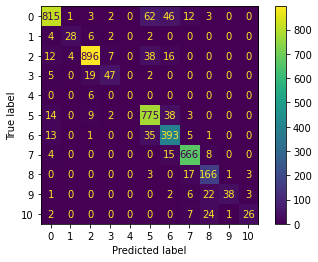

In [50]:
ConfusionMatrixDisplay(king_res[-1]["confusion_matrix"]).plot()
plt.show()

<a id='eval-dna'></a>
### 5.2 DNAtype prediction

In [43]:
dnatype = data_raw["DNAtype"]
np.sort(dnatype.unique()), dnatype.unique().size

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  9, 11, 12], dtype=int64), 11)

In [44]:
data_dna = data_raw.copy(deep=True)

In [45]:
condition = []
choices = []
# Setup conditions and choices
for count, key in enumerate(dnatype.unique()):
    condition.append(data_raw["DNAtype"] == key)  # unique kingdom 3-letter codes
    choices.append(count)  # integer now assigned to kingdom

data_dna["DNAtype_num"] = np.select(condition, choices)
data_dna.groupby("DNAtype_num").count()

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
DNAtype_num,,,,,,,,,,,,,,,,,,,,,
0,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265,...,9265,9265,9265,9265,9265,9265,9265,9265,9265,9265
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,31,31,31,31,31,31,31,31,31,31,...,31,31,31,31,31,31,31,31,31,31
3,816,816,816,816,816,816,816,816,816,816,...,816,816,816,816,816,816,816,816,816,816
4,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899,...,2899,2899,2899,2899,2899,2899,2899,2899,2899,2899
5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
6,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
8,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [46]:
data_drop_dna = data_dna[data_dna["DNAtype"].isin([0, 1, 2, 4])]
data_raw[~data_raw["DNAtype"].isin([0, 1, 2, 4])].count()

Kingdom        15
DNAtype        15
SpeciesID      15
Ncodons        15
SpeciesName    15
               ..
GAA            15
GAG            15
UAA            15
UAG            15
UGA            15
Length: 69, dtype: int64

In [47]:
labels = ["DNAtype_num"]
complete_data = data_drop_dna.iloc[:, 5:]
targets = data_drop_dna.loc[:, labels]
classes_n = len(targets.drop_duplicates(subset=labels))

In [48]:
DF_train_full, DF_test = train_test_split(
    complete_data,
    test_size=test_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=targets,
)
DF_train, DF_val, = train_test_split(
    DF_train_full,
    test_size=val_size,
    shuffle=True,
    random_state=RANDOM_SEED,
    stratify=DF_train_full[labels],
)

In [49]:
df_dict = {"train": DF_train, "val": DF_val, "test": DF_test}
for key, df_ in df_dict.items():
    print(f"{key}_data:\t size {df_.shape[0]:>3}")

train_data:	 size 7285
val_data:	 size 1822
test_data:	 size 3904


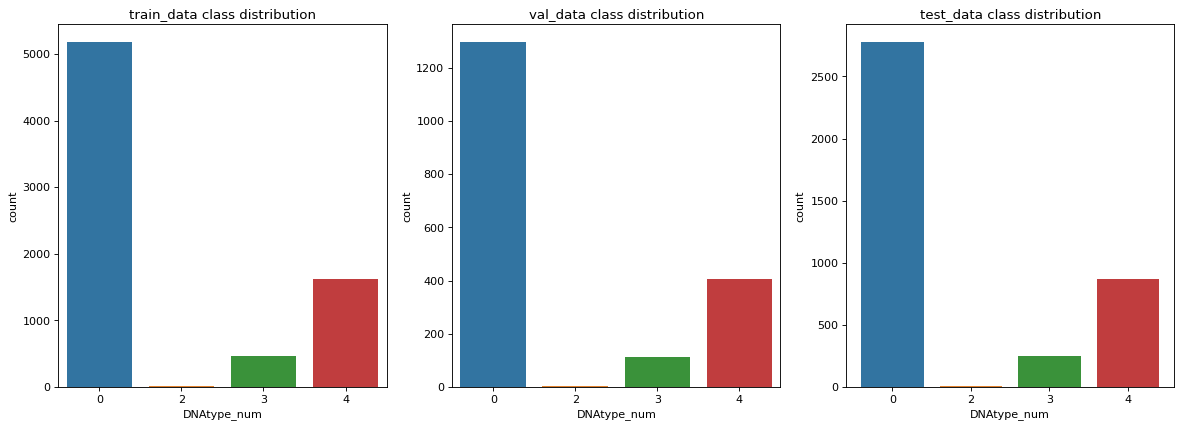

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=80)
for ax, (key, df_) in enumerate(df_dict.items()):
    sns.countplot(data=df_, x=labels[0], ax=axes[ax])
    axes[ax].set(title=f"{key}_data class distribution")
    plt.plot()

In [51]:
# Adjust labels
complete_data[labels] = np.where(complete_data[labels] == 4, 1, complete_data[labels])
targets = complete_data.loc[:, labels]

In [52]:
# Parameters
feature_n = final_data.shape[1]
classes_n = len(targets.drop_duplicates(subset=labels))
num_epochs = 100  # Now using more epochs
test_size = 0.3
val_size = 0.2
core_n = psutil.cpu_count(logical=False)
if core_n > 1:
    core_n = core_n - 1

In [54]:
best_params

,hidden_layer,learning_rate,batch_size,weights,fold,val_loss,val_accuracy,val_balanced_accuracy,val_f1,val_precision,val_recall,test_loss,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall
2,3,0.01,128,False,2.0,0.430057,0.912152,0.912152,0.77122,0.788283,0.782648,0.462939,0.907881,0.907881,0.763483,0.786004,0.77379


In [55]:
if best_params["weights"].iloc[0]:
    dna_weights = compute_class_weight(
        class_weight="balanced",
        classes=targets.drop_duplicates(subset=labels).iloc[:, 0],
        y=targets.iloc[:, 0].ravel(),
    )
    best_config["weights"] = [torch.Tensor(dna_weights)]
else:
    best_config["weights"] = [None]

In [ ]:
runs_eval = list()
dna_data = dict()
for idx, (train_index, test_index) in enumerate(
    skf_eval.split(complete_data.drop(columns=labels), complete_data[labels])
):
    X_train_full, X_test = complete_data.iloc[train_index], complete_data.iloc[test_index]
    X_train, X_val, = train_test_split(
        X_train_full,
        test_size=val_size,
        shuffle=True,
        random_state=RANDOM_SEED,
        stratify=X_train_full[labels],
    )
    scaler = MinMaxScaler()
    X_train_sc = scaler.fit_transform(X_train)
    X_val_sc = scaler.fit_transform(X_val)
    X_test_sc = scaler.transform(X_test)

    DF_train_sc = combine_to_df(X_train_sc, X_train, labels)
    DF_val_sc = combine_to_df(X_val_sc, X_val, labels)
    DF_test_sc = combine_to_df(X_test_sc, X_test, labels)
    runs_eval += hp_optimization(
        best_config,
        df_train=DF_train_sc,
        df_val=DF_val_sc,
        df_test=DF_test_sc,
        num_epochs=num_epochs,
        dev=False,
        cv=f"final_dna_{idx}",
    )
    dna_data[f"final_dna_{idx}"] = [DF_train_sc, DF_val_sc, DF_test_sc]

C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\pytorch_lightning\trainer\trainer.py:726: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000001FC690A79D0>
Traceback (most recent call last):
  File "C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "C:\Users\hjano\OneDrive\Uni\Master\Vorlesungen\07_Deep_Learning\practical_exercises\.venv\lib\site-packages\torch\utils\data\dataloader.py", line 1316, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception in thread Thread-5

In [ ]:
pd.DataFrame(runs_eval).head()

In [ ]:
pd.DataFrame(runs_eval).to_parquet(path="data/eval_dna", engine="pyarrow")

In [ ]:
eval_dna_result_df = pd.read_parquet(path="data/eval_dna", engine="pyarrow")

In [ ]:
eval_dna_result_df

In [ ]:
best_model_key = "final_dna_1"
best_config = best_params.iloc[:1, :].to_dict("list")
best_model = load_best_model(
    best_config,
    NeuralNet,
    feature_n=feature_n,
    classes_n=classes_n,
    device=device,
    cv=best_model_key,
)

In [ ]:
dna_res = list()
for key, items in dna_data.items():
    if key == best_model_key:
        for res_list in items:
            dna_res.append(
                compute_metrics(
                    best_model,
                    torch.tensor(res_list.drop(columns=labels).values, dtype=torch.float),
                    res_list[labels],
                )
            )

In [ ]:
pd.DataFrame(dna_res)

In [ ]:
ConfusionMatrixDisplay(dna_res[-1]["confusion_matrix"]).plot()
plt.show()

---
<a id='result'></a>

## 6. Result